In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import scipy.io as sio  # for loading matfile
from torchvision import datasets, transforms, utils,models
import numpy as np
import cv2
import random
import glob
import matplotlib.pyplot as plt

## Data Preprocessing

In [2]:
!wget --no-check-certificate \
  http://imagenet.stanford.edu/internal/car196/car_ims.tgz \
  -O /tmp/car_ims.tgz

--2020-07-02 19:43:21--  http://imagenet.stanford.edu/internal/car196/car_ims.tgz
Resolving imagenet.stanford.edu (imagenet.stanford.edu)... 171.64.68.16
Connecting to imagenet.stanford.edu (imagenet.stanford.edu)|171.64.68.16|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1956628579 (1.8G) [application/x-gzip]
Saving to: ‘/tmp/car_ims.tgz’

/tmp/car_ims.tgz    100%[===================>]   1.82G  34.8MB/s    in 76s     

2020-07-02 19:44:37 (24.5 MB/s) - ‘/tmp/car_ims.tgz’ saved [1956628579/1956628579]



In [3]:
!wget --no-check-certificate \
  http://imagenet.stanford.edu/internal/car196/cars_annos.mat \
  -O /tmp/cars_annos.mat


--2020-07-02 19:44:38--  http://imagenet.stanford.edu/internal/car196/cars_annos.mat
Resolving imagenet.stanford.edu (imagenet.stanford.edu)... 171.64.68.16
Connecting to imagenet.stanford.edu (imagenet.stanford.edu)|171.64.68.16|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 394471 (385K) [text/plain]
Saving to: ‘/tmp/cars_annos.mat’

/tmp/cars_annos.mat 100%[===================>] 385.23K  1.58MB/s    in 0.2s    

2020-07-02 19:44:38 (1.58 MB/s) - ‘/tmp/cars_annos.mat’ saved [394471/394471]



In [4]:
!wget --no-check-certificate \
  http://imagenet.stanford.edu/internal/car196/cars_test_annos_withlabels.mat \
  -O /tmp/cars_test_annos.mat


--2020-07-02 19:44:39--  http://imagenet.stanford.edu/internal/car196/cars_test_annos_withlabels.mat
Resolving imagenet.stanford.edu (imagenet.stanford.edu)... 171.64.68.16
Connecting to imagenet.stanford.edu (imagenet.stanford.edu)|171.64.68.16|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 185758 (181K) [text/plain]
Saving to: ‘/tmp/cars_test_annos.mat’

/tmp/cars_test_anno 100%[===================>] 181.40K   989KB/s    in 0.2s    

2020-07-02 19:44:39 (989 KB/s) - ‘/tmp/cars_test_annos.mat’ saved [185758/185758]



In [63]:
!rm -rf /tmp/car_ims/train/
!rm -rf /tmp/car_ims/test/
!rm -rf /tmp/car_ims/valid/

In [6]:
import os
import tarfile

local_tar = '/tmp/car_ims.tgz'

my_tar = tarfile.open(local_tar)
my_tar.extractall('/tmp')
my_tar.close()

In [64]:
def save_train_data(fnames, labels,bboxes):
    src_folder ='/tmp/car_ims'
    num_samples = len(fnames)

    train_split = 0.8
    num_train = int(round(num_samples * train_split))
    train_indexes = random.sample(range(num_samples), num_train)

    for i in range(num_samples):
        fname = fnames[i][8:]
        label = labels[i]
        (x1, y1, x2, y2) = bboxes[i]
        src_path = os.path.join(src_folder, fname)

        src_image = cv2.imread(src_path)
        height, width = src_image.shape[:2]

        # margins of 16 pixels (Crop image according to a given bounding box)
        margin = 16
        x1 = max(0, x1 - margin)
        y1 = max(0, y1 - margin)
        x2 = min(x2 + margin, width)
        y2 = min(y2 + margin, height)

        if i in train_indexes:
            dst_folder = '/tmp/car_ims/train/'
        else:
            dst_folder = '/tmp/car_ims/valid/'

        dst_path = os.path.join(dst_folder, label)
        if not os.path.exists(dst_path):
            os.makedirs(dst_path)
        dst_path = os.path.join(dst_path, fname)
        dst_image = src_image[y1:y2, x1:x2]
        cv2.imwrite(dst_path, dst_image)

In [65]:
car_annotation= sio.loadmat('/tmp/cars_annos.mat')

annotations = car_annotation['annotations']
annotations = np.transpose(annotations)

fnames = []
class_ids = []
labels = []
bboxes  = []
for annotation in annotations:
  bbox_x1 = annotation[0][1][0][0]
  bbox_y1 = annotation[0][2][0][0]
  bbox_x2 = annotation[0][3][0][0]
  bbox_y2 = annotation[0][4][0][0]

  class_id = annotation[0][5][0][0]
  bboxes.append((bbox_x1, bbox_y1, bbox_x2, bbox_y2))
  labels.append(f'{class_id:06}')

  file_name = annotation[0][0][0]
  class_ids.append(class_id)
  fnames.append(file_name)

labels_count = np.unique(class_ids).shape[0]
print(np.unique(class_ids))
print('The number of different cars is %d' % labels_count)

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196]
The number of different cars is 196


In [66]:
save_train_data(fnames, labels, bboxes)

In [67]:
print(glob.glob("/tmp/car_ims/train/*"))
print(glob.glob("/tmp/car_ims/valid/*"))

['/tmp/car_ims/train/000028', '/tmp/car_ims/train/000178', '/tmp/car_ims/train/000129', '/tmp/car_ims/train/000179', '/tmp/car_ims/train/000025', '/tmp/car_ims/train/000045', '/tmp/car_ims/train/000150', '/tmp/car_ims/train/000058', '/tmp/car_ims/train/000039', '/tmp/car_ims/train/000130', '/tmp/car_ims/train/000131', '/tmp/car_ims/train/000194', '/tmp/car_ims/train/000073', '/tmp/car_ims/train/000159', '/tmp/car_ims/train/000114', '/tmp/car_ims/train/000090', '/tmp/car_ims/train/000031', '/tmp/car_ims/train/000133', '/tmp/car_ims/train/000010', '/tmp/car_ims/train/000123', '/tmp/car_ims/train/000138', '/tmp/car_ims/train/000061', '/tmp/car_ims/train/000102', '/tmp/car_ims/train/000103', '/tmp/car_ims/train/000105', '/tmp/car_ims/train/000062', '/tmp/car_ims/train/000177', '/tmp/car_ims/train/000032', '/tmp/car_ims/train/000044', '/tmp/car_ims/train/000139', '/tmp/car_ims/train/000167', '/tmp/car_ims/train/000195', '/tmp/car_ims/train/000096', '/tmp/car_ims/train/000136', '/tmp/car_ims

In [68]:
train_dir='/tmp/car_ims/train/'
validation_dir='/tmp/car_ims/valid/'

In [69]:
trainset = datasets.ImageFolder(train_dir,transform=transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])]))
valset = datasets.ImageFolder(validation_dir, transform=transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])]))

In [70]:
batch_size=32
test_batch_size=32
train_loader = torch.utils.data.DataLoader(trainset,batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(valset,batch_size=test_batch_size, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 3, 224, 224])


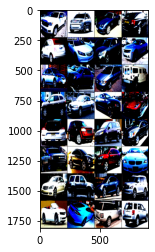

In [71]:
(inp_tensor,label)= next(iter(train_loader))
print(inp_tensor.size())
grid_img = utils.make_grid(inp_tensor, nrow=4)
plt.imshow(grid_img.permute(1, 2, 0))

In [72]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data=data.to('cuda')
        target=target.to('cuda')
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    print('Train Epoch: {}, Loss: {:.3f}'.format(epoch, loss.item()))


def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data=data.to('cuda')
            target=target.to('cuda')
            output = model(data)
            _, pred = output.max(1)
            test_loss += criterion(output, target).item() 
            correct += pred.eq(target).sum().item()
            total += target.size(0)

    test_loss /= len(test_loader.dataset)

    print('Average loss: {:.3f}, Test Acc: {:.3f} ({}/{})'.format(test_loss, 100.*correct/total, correct, total))

In [ ]:
resnet50 = models.resnet50(pretrained=True)
print(resnet50.fc)
resnet50.fc= nn.Linear(2048,196)
resnet50=resnet50.to('cuda')
epochs=5
optimizer = optim.Adam(resnet50.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss().to('cuda')

for epoch in range(1, epochs + 1):
    train(resnet50, train_loader, optimizer, epoch)
    test(resnet50, val_loader)

Linear(in_features=2048, out_features=1000, bias=True)
Train Epoch: 1, Loss: 5.014
Average loss: 0.164, Test Acc: 0.834 (27/3237)
Train Epoch: 2, Loss: 4.791
Average loss: 0.165, Test Acc: 1.050 (34/3237)
Train Epoch: 3, Loss: 4.820
Average loss: 0.148, Test Acc: 2.595 (84/3237)
Train Epoch: 4, Loss: 4.401
Average loss: 0.141, Test Acc: 4.078 (132/3237)
